# Day 3: Triple-Barrier Labeling Method

## 🎯 Learning Objectives
- Understand limitations of fixed-horizon labeling
- Implement triple-barrier method from "Advances in Financial Machine Learning"
- Create meaningful trading labels
- Apply to classification models

---

## 📚 Theory: Triple-Barrier Method (Marcos López de Prado)

### Problem with Fixed-Horizon Labels
Traditional approach: Label = sign(return over N days)
- Ignores path dependency
- Doesn't reflect trading reality (stop-losses, take-profits)
- Creates noisy labels

### Triple-Barrier Solution
Three barriers that can be hit:
1. **Upper Barrier (Take-Profit)**: Price hits profit target
2. **Lower Barrier (Stop-Loss)**: Price hits stop-loss
3. **Vertical Barrier (Time)**: Holding period expires

### Label Assignment
$$y = \begin{cases} 1 & \text{Upper barrier hit first (profit)} \\ -1 & \text{Lower barrier hit first (loss)} \\ 0 & \text{Vertical barrier hit (no signal)} \end{cases}$$

### Dynamic Barriers
Barriers can be set relative to volatility:
- Upper = Entry Price × (1 + k × σ)
- Lower = Entry Price × (1 - k × σ)

### Pros & Cons

| Pros | Cons |
|------|------|
| Reflects trading reality | More complex to implement |
| Path-dependent labels | Class imbalance possible |
| Volatility-adjusted | Requires barrier tuning |
| Better signal quality | Looks-ahead for labeling |

---

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=7*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)

# Handle multi-level columns from yfinance
if isinstance(data.columns, pd.MultiIndex):
    prices = data['Close'][ticker]
else:
    prices = data['Close']
    
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days for {ticker}")

📥 Downloading data...
✅ Data: 1758 days for AAPL


In [14]:
def get_daily_volatility(close, span=20):
    """Calculate rolling volatility."""
    return close.pct_change().ewm(span=span).std()

def get_triple_barrier_labels(close, volatility, 
                              upper_multiplier=2.0, 
                              lower_multiplier=2.0,
                              max_holding_period=10):
    """
    Implement triple-barrier labeling method.
    
    Parameters:
    - close: Price series
    - volatility: Rolling volatility
    - upper_multiplier: Multiplier for upper barrier (take-profit)
    - lower_multiplier: Multiplier for lower barrier (stop-loss)
    - max_holding_period: Vertical barrier (max days)
    
    Returns:
    - labels: 1 (profit), -1 (loss), 0 (timeout)
    - exit_times: When each trade exited
    - returns: Return at exit
    """
    labels = []
    exit_times = []
    exit_returns = []
    barrier_hit = []
    
    for i in range(len(close) - max_holding_period):
        entry_price = close.iloc[i]
        entry_vol = volatility.iloc[i]
        
        if pd.isna(entry_vol) or entry_vol == 0:
            labels.append(np.nan)
            exit_times.append(np.nan)
            exit_returns.append(np.nan)
            barrier_hit.append(np.nan)
            continue
        
        # Set barriers
        upper_barrier = entry_price * (1 + upper_multiplier * entry_vol)
        lower_barrier = entry_price * (1 - lower_multiplier * entry_vol)
        
        # Check future prices
        future_prices = close.iloc[i+1:i+max_holding_period+1]
        
        # Find first barrier hit
        upper_hits = future_prices[future_prices >= upper_barrier]
        lower_hits = future_prices[future_prices <= lower_barrier]
        
        upper_time = upper_hits.index[0] if len(upper_hits) > 0 else None
        lower_time = lower_hits.index[0] if len(lower_hits) > 0 else None
        vertical_time = future_prices.index[-1]
        
        # Determine which barrier was hit first
        if upper_time and lower_time:
            if upper_time <= lower_time:
                label, exit_time, which = 1, upper_time, 'upper'
            else:
                label, exit_time, which = -1, lower_time, 'lower'
        elif upper_time:
            label, exit_time, which = 1, upper_time, 'upper'
        elif lower_time:
            label, exit_time, which = -1, lower_time, 'lower'
        else:
            label, exit_time, which = 0, vertical_time, 'vertical'
        
        exit_price = close.loc[exit_time]
        exit_ret = (exit_price - entry_price) / entry_price
        
        labels.append(label)
        exit_times.append(exit_time)
        exit_returns.append(exit_ret)
        barrier_hit.append(which)
    
    # Pad with NaN for the last max_holding_period days
    labels.extend([np.nan] * max_holding_period)
    exit_times.extend([np.nan] * max_holding_period)
    exit_returns.extend([np.nan] * max_holding_period)
    barrier_hit.extend([np.nan] * max_holding_period)
    
    return pd.Series(labels, index=close.index), pd.Series(exit_returns, index=close.index), pd.Series(barrier_hit, index=close.index)

# Calculate volatility
volatility = get_daily_volatility(prices, span=20)

# Get triple-barrier labels
labels, exit_returns, barrier_hit = get_triple_barrier_labels(
    prices, volatility, 
    upper_multiplier=2.0,
    lower_multiplier=2.0,
    max_holding_period=10
)

print("\n✅ Triple-barrier labels computed")


✅ Triple-barrier labels computed


In [6]:
# Analyze label distribution
label_counts = labels.value_counts().sort_index()

print("\n" + "="*60)
print("TRIPLE-BARRIER LABEL DISTRIBUTION")
print("="*60)
print(f"\n{'-1 (Loss)':<20}: {label_counts.get(-1, 0):>6} ({label_counts.get(-1, 0)/labels.notna().sum():.1%})")
print(f"{'0 (Timeout)':<20}: {label_counts.get(0, 0):>6} ({label_counts.get(0, 0)/labels.notna().sum():.1%})")
print(f"{'1 (Profit)':<20}: {label_counts.get(1, 0):>6} ({label_counts.get(1, 0)/labels.notna().sum():.1%})")

# Barrier hit analysis
barrier_counts = barrier_hit.value_counts()
print(f"\n📊 Barrier Hit Distribution:")
for barrier, count in barrier_counts.items():
    if pd.notna(barrier):
        print(f"   {barrier}: {count} ({count/barrier_hit.notna().sum():.1%})")


TRIPLE-BARRIER LABEL DISTRIBUTION

-1 (Loss)           :    530 (30.4%)
0 (Timeout)         :    388 (22.2%)
1 (Profit)          :    828 (47.4%)

📊 Barrier Hit Distribution:
   upper: 828 (47.4%)
   lower: 530 (30.4%)
   vertical: 388 (22.2%)


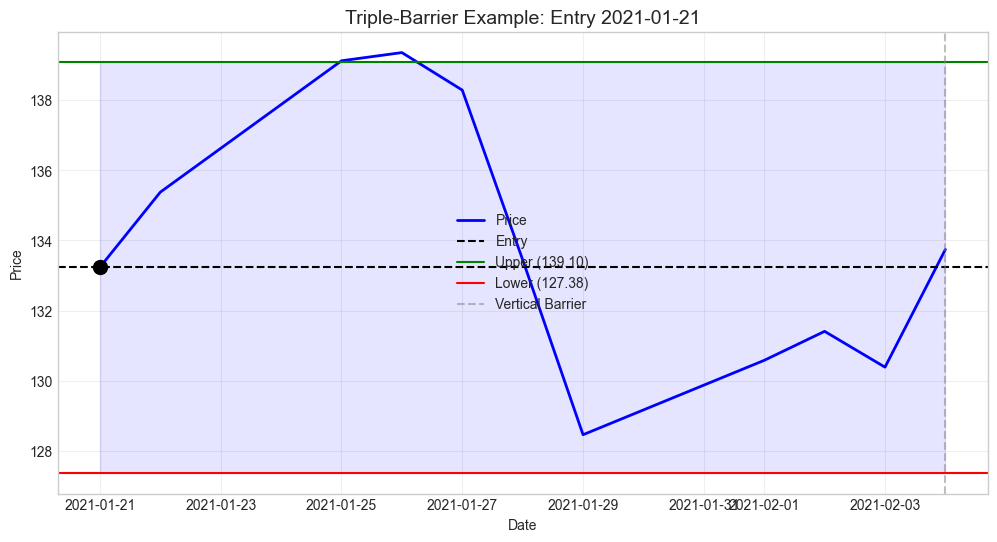


Label: 1.0, Return: 4.42%, Barrier: upper


In [7]:
# Visualize a specific example
def plot_triple_barrier_example(close, volatility, start_idx, 
                                upper_mult=2.0, lower_mult=2.0, max_hold=10):
    """Visualize triple-barrier for a specific trade."""
    entry_price = close.iloc[start_idx]
    entry_vol = volatility.iloc[start_idx]
    entry_date = close.index[start_idx]
    
    upper = entry_price * (1 + upper_mult * entry_vol)
    lower = entry_price * (1 - lower_mult * entry_vol)
    
    # Get price path
    end_idx = min(start_idx + max_hold + 1, len(close))
    path = close.iloc[start_idx:end_idx]
    
    plt.figure(figsize=(12, 6))
    plt.plot(path.index, path.values, 'b-', linewidth=2, label='Price')
    plt.axhline(y=entry_price, color='black', linestyle='--', label='Entry')
    plt.axhline(y=upper, color='green', linestyle='-', label=f'Upper ({upper:.2f})')
    plt.axhline(y=lower, color='red', linestyle='-', label=f'Lower ({lower:.2f})')
    plt.axvline(x=path.index[-1], color='gray', linestyle='--', alpha=0.5, label='Vertical Barrier')
    
    plt.fill_between(path.index, lower, upper, alpha=0.1, color='blue')
    plt.scatter([entry_date], [entry_price], color='black', s=100, zorder=5)
    
    plt.title(f'Triple-Barrier Example: Entry {entry_date.strftime("%Y-%m-%d")}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return labels.iloc[start_idx], exit_returns.iloc[start_idx], barrier_hit.iloc[start_idx]

# Find a good example (not NaN)
valid_idx = labels[labels.notna()].index
example_idx = np.where(prices.index == valid_idx[500])[0][0]

label, ret, barrier = plot_triple_barrier_example(prices, volatility, example_idx)
print(f"\nLabel: {label}, Return: {ret:.2%}, Barrier: {barrier}")


LABEL COMPARISON: TRIPLE-BARRIER vs FIXED-HORIZON


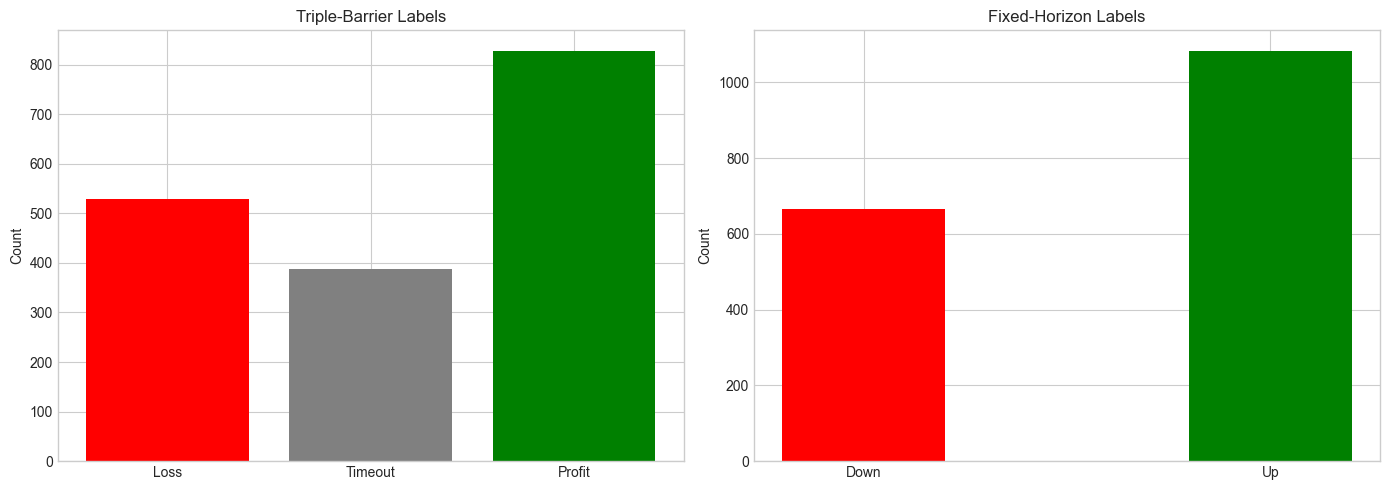

In [8]:
# Compare with fixed-horizon labels
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['triple_barrier_label'] = labels
df['triple_barrier_return'] = exit_returns

# Fixed horizon labels (same holding period)
horizon = 10
df['fixed_return'] = prices.pct_change(horizon).shift(-horizon)
df['fixed_label'] = np.sign(df['fixed_return'])

# Compare label distributions
print("\n" + "="*60)
print("LABEL COMPARISON: TRIPLE-BARRIER vs FIXED-HORIZON")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Triple-barrier
tb_counts = df['triple_barrier_label'].value_counts().sort_index()
axes[0].bar(tb_counts.index, tb_counts.values, color=['red', 'gray', 'green'])
axes[0].set_xticks([-1, 0, 1])
axes[0].set_xticklabels(['Loss', 'Timeout', 'Profit'])
axes[0].set_title('Triple-Barrier Labels')
axes[0].set_ylabel('Count')

# Fixed-horizon
fh_counts = df['fixed_label'].value_counts().sort_index()
axes[1].bar(fh_counts.index, fh_counts.values, color=['red', 'green'])
axes[1].set_xticks([-1, 1])
axes[1].set_xticklabels(['Down', 'Up'])
axes[1].set_title('Fixed-Horizon Labels')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [9]:
# Create features
df['momentum_5'] = prices.pct_change(5)
df['momentum_10'] = prices.pct_change(10)
df['momentum_20'] = prices.pct_change(20)
df['volatility_10'] = returns.rolling(10).std()
df['volatility_20'] = returns.rolling(20).std()
df['ma_ratio'] = prices / prices.rolling(20).mean() - 1
df['rsi'] = 100 - (100 / (1 + returns.where(returns > 0, 0).rolling(14).mean() / 
                          (-returns.where(returns < 0, 0)).rolling(14).mean()))

df = df.dropna()

# For classification, convert to binary (1 for profit, 0 for loss/timeout)
df['target_binary'] = (df['triple_barrier_label'] == 1).astype(int)

print(f"\n📊 Dataset size: {len(df)}")
print(f"   Positive (Profit): {df['target_binary'].sum()} ({df['target_binary'].mean():.1%})")


📊 Dataset size: 1728
   Positive (Profit): 826 (47.8%)


In [10]:
# Train classifier with triple-barrier labels
feature_cols = ['momentum_5', 'momentum_10', 'momentum_20', 
                'volatility_10', 'volatility_20', 'ma_ratio', 'rsi']
X = df[feature_cols]
y = df['target_binary']

# Split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['triple_barrier_return'].iloc[split_idx:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("TRIPLE-BARRIER CLASSIFICATION RESULTS")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\n" + classification_report(y_test, y_pred, target_names=['Not Profit', 'Profit']))


TRIPLE-BARRIER CLASSIFICATION RESULTS

Accuracy: 55.20%

              precision    recall  f1-score   support

  Not Profit       0.68      0.53      0.60       215
      Profit       0.43      0.58      0.50       131

    accuracy                           0.55       346
   macro avg       0.55      0.56      0.55       346
weighted avg       0.58      0.55      0.56       346



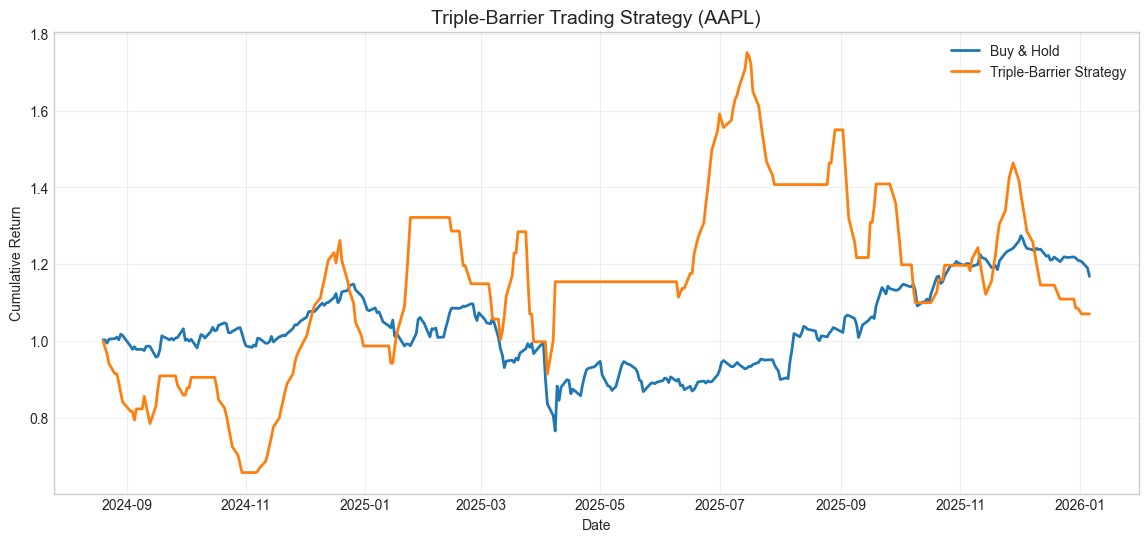

In [11]:
# Trading backtest with triple-barrier classifier
backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values
backtest['signal'] = y_pred
backtest['probability'] = y_proba

# Strategy: Enter when predicted profit, use actual triple-barrier return
backtest['strategy_return'] = backtest['signal'] * backtest['actual_return']

# For buy-hold, use simple daily returns
daily_returns = df['price'].pct_change().iloc[split_idx:]
backtest['buy_hold_return'] = daily_returns.values

# Cumulative
backtest['strategy_cum'] = (1 + backtest['strategy_return'].fillna(0)).cumprod()
backtest['buy_hold_cum'] = (1 + backtest['buy_hold_return'].fillna(0)).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['strategy_cum'], label='Triple-Barrier Strategy', linewidth=2)
plt.title(f'Triple-Barrier Trading Strategy ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Performance summary
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

bh_total, bh_sharpe, bh_mdd = calc_metrics(backtest['buy_hold_return'].fillna(0), backtest['buy_hold_cum'])
st_total, st_sharpe, st_mdd = calc_metrics(backtest['strategy_return'].fillna(0), backtest['strategy_cum'])

print(f"\n{'Strategy':<25} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 60)
print(f"{'Buy & Hold':<25} {bh_total:>12.2%} {bh_sharpe:>10.2f} {bh_mdd:>10.2%}")
print(f"{'Triple-Barrier Strategy':<25} {st_total:>12.2%} {st_sharpe:>10.2f} {st_mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                     Total Ret     Sharpe     Max DD
------------------------------------------------------------
Buy & Hold                      16.80%       0.36    -33.36%
Triple-Barrier Strategy          7.01%       0.21    -38.90%


In [13]:
# Next prediction
latest_scaled = scaler.transform(X.iloc[[-1]])
next_pred = rf.predict(latest_scaled)[0]
next_proba = rf.predict_proba(latest_scaled)[0, 1]

print("\n" + "="*60)
print(f"📊 NEXT TRIPLE-BARRIER PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Prediction: {'📈 ENTER TRADE (Profit Expected)' if next_pred == 1 else '⏸️ WAIT (No Clear Profit Signal)'}")
print(f"Probability of Profit: {next_proba:.2%}")


📊 NEXT TRIPLE-BARRIER PREDICTION FOR AAPL

Date: 2026-01-06
Prediction: ⏸️ WAIT (No Clear Profit Signal)
Probability of Profit: 31.94%


---

## 🏢 Real-World Applications

| Company | Triple-Barrier Use Case |
|---------|-----------------------|
| Hudson River Trading | Order flow prediction |
| Citadel | Execution timing |
| AQR | Signal generation pipeline |
| WorldQuant | Alpha research labeling |

### Key Interview Points
1. **Why triple-barrier?** - Reflects trading reality with stops and targets
2. **Barrier setting?** - Use volatility-adjusted barriers, tune via backtest
3. **Class imbalance?** - Common with asymmetric barriers, use sampling techniques
4. **Look-ahead bias?** - Labeling uses future data, but features must not!

---
## 📅 Tomorrow: Meta-Labeling